# Personality classification according to sentences

# 1 - Data Preprocessing

## 1.0. Data Collection

In [1]:
# Code to download file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '16g474hdNsaNx0_SnoKuqj2BuwSEGdnbt'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('training_data.csv')  

id = '1-7hj0sF3Rc5G6POKdkpbDXm_Q6BWFDPU'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('testing_data.csv')  

import pandas as pd
training_data = pd.read_csv("/content/training_data.csv")
testing_data = pd.read_csv("/content/testing_data.csv")

print("------------------------------------")
print("Size of training dataset: {0}".format(len(training_data)))
print("Size of testing dataset: {0}".format(len(testing_data)))
print("------------------------------------")

print("------------------------------------")
print("Sample Data")
print("LABEL: {0} / SENTENCE: {1}".format(training_data.iloc[-1,0], training_data.iloc[-1,1]))
print("------------------------------------")


------------------------------------
Size of training dataset: 7808
Size of testing dataset: 867
------------------------------------
------------------------------------
Sample Data
LABEL: F / SENTENCE: 'Half of it is going straight to charity, another quarter going straight to scientific research, an eighth to the parkour community, a sixteenth to towards spreading information about health and...|||Find a path or suffer more.|||http://personalitycafe.com/enneagram-personality-theory-forum/85323-enneagram-type-mbti-type-compared-statistics.html yep.|||I kind of anchor on Fi and Ne makes having Ni really fun. INFP for me as they tire me out less and our views tend to align more.|||The two ESTPs I have gotten the chance to know seem to experience much more than other people who have been on the planet for the same amount of time and are quite the renaissance (wo)men.  Is this...|||I don't really have a best friend ISTP(passion-amateur group co-founder), INTJ(intellectual and various sma

In [2]:
# Preview of the data in the csv file, which has two columns: 
# (1)type - label of the post (2)posts - the corresponding post content
training_data.head()

,type,posts
0,F,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,T,'I'm finding the lack of me in these posts ver...
2,T,'Good one _____ https://www.youtube.com/wat...
3,T,"'Dear INTP, I enjoyed our conversation the o..."
4,T,'You're fired.|||That's another silly misconce...


In [3]:
# Extract the labels and posts and store into List

# Get the list of training data (posts)
training_posts=training_data['posts'].tolist()
# Get the list of corresponding labels for the training data (posts)
training_labels=training_data['type'].tolist()

# Get the list of testing data (posts)
testing_posts=testing_data['posts'].tolist()
# Get the list of corresponding labels for the testing data (posts)
testing_labels=testing_data['type'].tolist()

## 1.1. URL Removal

In [4]:
# Remove URL
def remove_url(data):
  import re
  # Url pattern
  URL_Pattern = 'http\S+'
  return [re.sub(URL_Pattern, '', sentence) for sentence in data]

## 1.2. Preprocess data (e.g. Stop words, Stemming)
*related to the section 4.2*

In [5]:
# Map contraction to full words
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
            "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
            "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", 
            "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", 
            "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
            "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
            "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
            "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
            "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
            "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", 
            "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
            "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
            "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
            "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", 
            "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
            "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
            "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
            "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", 
            "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
            "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
            "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
            "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def remove_contraction(data):
  result = []
  for x in data:  
    words = x[1:-1].split(' ')
    link = ' '
    result_words = []
    for word in words:
      if word in contraction_dict.keys():
        result_words.append(contraction_dict[word])
      else: result_words.append(word)
    result.append(link.join(result_words))
  return result


In [6]:
# Remove puncts
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def remove_punctuation(data):
  result = []
  for sentence in data:
    sentence = str(sentence)
    for punct in puncts:
      if punct in sentence:
        sentence = sentence.replace(punct, '')
    result.append(sentence)
  return result


In [7]:
# Tokenization
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords as sw
from nltk.tokenize import word_tokenize


def tokenize_data(data):
  return [word_tokenize(sentence) for sentence in data]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
# 1. Remove stop words

stop_words = sw.words()
def remove_stop_words(data):
  return [[w for w in sentence if not w in stop_words] for sentence in data]


In [9]:
# 2. Stemming
from nltk.stem.snowball import *
stemmer = SnowballStemmer('english')

def stemming(data):
  return [[stemmer.stem(word) for word in sentence] for sentence in data]

In [10]:
# 3. Lemmatisation

nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatisation(data):
  return [[lemmatizer.lemmatize(word) for word in sentence] for sentence in data]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [11]:
# 4. Remove numbers
def remove_numbers(data):
  result = []
  for sentence in data:
    temp = []
    for word in sentence:
      word = re.sub(r'\d+', '', word)
      if len(word) != 0:
        temp.append(word)
    result.append(temp)
  return result

In [12]:
# Without URL

training_data_after_removing_url_punct_contraction = remove_punctuation(remove_contraction(remove_url(training_posts)))
testing_data_after_removing_url_punct_contraction = remove_punctuation(remove_contraction(remove_url(testing_posts)))
for i in range(0,3):
  print(training_data_after_removing_url_punct_contraction[i])
  print(testing_data_after_removing_url_punct_contraction[i])


 and intj moments    sportscenter not top ten plays    pranksWhat has been the most lifechanging experience in your life     On repeat for most of todayMay the PerC Experience immerse youThe last thing my INFJ friend posted on his facebook before committing suicide the next day Rest in peace    ENFJ7 Sorry to hear of your distress Its only natural for a relationship to not be perfection all the time in every moment of existence Try to figure the hard times as times of growth as84389  84390     Welcome and stuff  Game Set MatchProzac wellbrutin at least thirty minutes of moving your legs and I do not mean moving them while sitting in your same desk chair weed in moderation maybe try edibles as a healthier alternativeBasically come up with three items you have determined that each type or whichever types you want to do would more than likely use given each types cognitive functions and whatnot when left byAll things in moderation  Sims is indeed a video game and a good one at that Note a

In [13]:
# With URL

training_data_after_removing_punct_contraction = remove_punctuation(remove_contraction(training_posts))
testing_data_after_removing_punct_contraction = remove_punctuation(remove_contraction(testing_posts))
for i in range(0,3):
  print(training_data_after_removing_punct_contraction[i])
  print(testing_data_after_removing_punct_contraction[i])

httpwwwyoutubecomwatchvqsXHcwe3krwhttp41mediatumblrcomtumblrlfouy03PMA1qa1rooo1500jpgenfp and intj moments  httpswwwyoutubecomwatchviz7lE1g4XM4  sportscenter not top ten plays  httpswwwyoutubecomwatchvuCdfze1etec  pranksWhat has been the most lifechanging experience in your lifehttpwwwyoutubecomwatchvvXZeYwwRDw8   httpwwwyoutubecomwatchvu8ejam5DP3E  On repeat for most of todayMay the PerC Experience immerse youThe last thing my INFJ friend posted on his facebook before committing suicide the next day Rest in peace   httpvimeocom22842206Hello ENFJ7 Sorry to hear of your distress Its only natural for a relationship to not be perfection all the time in every moment of existence Try to figure the hard times as times of growth as84389  84390  httpwallpaperpassioncomupload23700friendshipboyandgirlwallpaperjpg  httpassetsdornobcomwpcontentuploads201004roundhomedesignjpg Welcome and stuffhttpplayeressencecomwpcontentuploads201308REDredthepokemonmaster32560474450338jpg  Game Set MatchProzac wel

In [14]:
# Test with URL
training_data_with_url = tokenize_data(training_data_after_removing_punct_contraction)
testing_data_with_url = tokenize_data(testing_data_after_removing_punct_contraction)

In [15]:
# Test without URL
training_data_without_url = tokenize_data(training_data_after_removing_url_punct_contraction)
testing_data_without_url = tokenize_data(testing_data_after_removing_punct_contraction)

In [16]:
# After comparing corpus with URL and without URL, I choose corpus without URL
# Combination of  1&2 (Removing Stopwords and stemming)
training_token = training_data_without_url
testing_token = testing_data_without_url

training_data_1_2 = stemming(remove_stop_words(training_token))
testing_data_1_2 = stemming(remove_stop_words(testing_token))

In [17]:
# Combination of  3&4 (Removing numbers and lemmatisation)
training_data_3_4 = lemmatisation(remove_numbers(training_token))
testing_data_3_4 = lemmatisation(remove_numbers(testing_token))

In [18]:
# 4 kinds of corpus should be tested
# with URL
corpus_with_url = training_data_with_url + testing_data_with_url
# without URL
corpus_without_url = training_data_without_url + testing_data_without_url
# Remove stopwords and stemming
corpus_1_2 = training_data_1_2 + testing_data_1_2
# Remove numbers and lemmatisation
corpus_3_4 = training_data_3_4 + testing_data_3_4


In [19]:
# *************************************************************************
# !!!!!!Only change here to test different pre-processing techniques
# *************************************************************************
corpus = corpus_1_2
training_data_after_preprocessing = training_data_1_2
testing_data_after_preprocessing = testing_data_1_2

In [20]:
# Get the vocabulary list from the training data for creating the lookup table later
# In practice, we only use the vocabulary from training data

def generate_word_list_dict(corpus):
  word_set = set() 
  for sent in corpus:
      for word in sent:
          word_set.add(word)

  # Normally we add the special tokens for representing the padding and unknown words separately
  # Sometimes we can also use same token to present padding and unknown words if we don't have to differentiate them
  word_set.add('[PAD]')
  word_set.add('[UNKNOWN]')

  word_list = list(word_set) 

  # Although in some python versions, converting a set to list will return a ordered result, 
  # It is still highly recommended that you sort this list to ensure the reproducibility of your code
  word_list.sort()

  word_index = {}
  ind = 0
  for word in word_list:
      word_index[word] = ind
      ind += 1
  return word_list, word_index

word_list, word_index = generate_word_list_dict(corpus)

In [21]:
# Convert the sentences to the word index that aligns with the lookup table

len_list = [len(s) for s in training_data_after_preprocessing]
seq_length = max(len_list)

# Padding and encoding
def encode_and_add_padding(sentences, seq_length, word_index):
    sent_encoded = []
    for sent in sentences:
        temp_encoded = [word_index[word] if word in word_index else word_index['[UNKNOWN]'] for word in sent]
        if len(temp_encoded) < seq_length:
            temp_encoded += [word_index['[PAD]']] * (seq_length - len(temp_encoded))
        sent_encoded.append(temp_encoded)
    return sent_encoded

sent_encoded = encode_and_add_padding(training_data_after_preprocessing, seq_length, word_index)
test_encoded = encode_and_add_padding(testing_data_after_preprocessing, seq_length, word_index)

In [22]:
from sklearn.preprocessing import LabelEncoder

lEnc = LabelEncoder()
lEnc.fit(training_labels)
label_encoded= lEnc.transform(training_labels)

lEnc.fit(testing_labels)
label_encoded_testing = lEnc.transform(testing_labels)

# 2 - Input Representation


## 2.1. Word Embedding Construction

In [23]:
# CBOW

from gensim.models import Word2Vec
wv_cbow_model = Word2Vec(sentences=corpus, size=200, window=5, min_count=5, workers=2, sg=0)

In [24]:
# SG

wv_sg_model = Word2Vec(sentences=corpus, size=200, window=5, min_count=5, workers=2, sg=1)

## 2.2. Pretrained Word Embedding

In [25]:
# Glove-twitter-100

import gensim.downloader as api
word_pretrained_model_gt = api.load("glove-twitter-100")

[==================================================] 100.0% 387.1/387.1MB downloaded


In [26]:
# Glove-wiki-gigaword-100

word_pretrained_model_gwg = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
# ****************************************************************************************************************
# !!!!!!Only change here to test different combination of Word2Vec model, choose one of them to run.
# The first block is testing single Word2Vec, the second is testing their combination
# ****************************************************************************************************************

In [29]:
# Here I test different Word2Vec Models
my_model = wv_cbow_model

import numpy as np
emb_dim = my_model.vector_size

# Embedding lookup table via concatenation
emb_table = []
for i, word in enumerate(word_list):
    if word in my_model:
        emb_table.append(my_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


## 2.3. Input Concatenation

In [28]:
# Here I test different combinations of Word2Vec Model
my_model = wv_sg_model
pre_trained_model = word_pretrained_model_gwg

import numpy as np
emb_dim = my_model.vector_size + pre_trained_model.vector_size

# Embedding lookup table via concatenation
emb_table = []
for i, word in enumerate(word_list):
    if word in my_model and word in pre_trained_model:
        emb_table.append(np.concatenate((my_model[word],pre_trained_model[word]),0))
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


# 3 - Model Implementation

### 3.1. Build Sequence Model (Bi-directional model)

In [32]:
from sklearn.metrics import f1_score
# Setup for the modeling and training
vocab_size = len(word_list)
unique_labels = np.unique(training_labels)
n_class = len(unique_labels)
n_hidden = 32
# batch_size
batch_size = 128

# Set hyperparameters
# change here to test different epoch number
learning_rate = 0.01
total_epoch = 10

In [ ]:
# ****************************************************************************************************************
# !!!!!!Only change here to test different Seq2Seq model, choose one of them to run.
# The first block is testing Bi-LSTM, the second is testing Bi-RNN
# ****************************************************************************************************************

In [33]:
# Build Bi-LSTM model


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class Bi_LSTM_Emb(nn.Module):
    def __init__(self):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        lstm_out, (h_n, c_n) = self.lstm(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

In [116]:
# Build Bi-RNN model

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class Bi_RNN_Emb(nn.Module):
    def __init__(self):
        super(Bi_RNN_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        # [IMPORTANT] Initialize the Embedding layer with the lookup table we created 
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        # Optional: set requires_grad = False to make this lookup table untrainable
        self.emb.weight.requires_grad = False

        self.rnn = nn.RNN(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_class)

    def forward(self, x):
        # Get the embeded tensor
        x = self.emb(x)        
        # we will use the returned h_n of shape (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t = seq_len.
        # details of the outputs from nn.LSTM can be found from: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        rnn_out, h_n = self.rnn(x)
        # concat the last hidden state from two direction
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return z

### 3.2. Train Sequence Model (Bi-directional model)

In [34]:
# Move the model to GPU

model = Bi_LSTM_Emb().to(device)
# model = Bi_RNN_Emb().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Preparing input

input_torch = torch.from_numpy(np.array(sent_encoded)).to(device)
targe_torch = torch.from_numpy(np.array(label_encoded)).view(-1).to(device)

for epoch in range(total_epoch):  
    batch = 0
    loss_sum = 0
    for ind in range(0, len(input_torch), batch_size):
      
      # Set the flag to training
      model.train()
      # forward + backward + optimize
      optimizer.zero_grad()
      outputs = model(input_torch[ind:min(ind+batch_size, len(input_torch))]) 
      loss = criterion(outputs, targe_torch[ind:min(ind+batch_size, len(input_torch))])
      loss.backward()
      optimizer.step()
      batch += 1
      loss_sum += loss.item()
    print('Epoch: %d, loss: %.5f' %(epoch + 1, loss_sum))
    if((epoch + 1) % 10 == 0):
      predict = torch.argmax(model(torch.from_numpy(np.array(test_encoded))), -1)
      f1 = f1_score(label_encoded_testing, predict)
      print('F1 Score: %.5f' %(f1))

print('Finished Training')

Epoch: 1, loss: 40.38344
Epoch: 2, loss: 36.41560
Epoch: 3, loss: 34.31927
Epoch: 4, loss: 28.85502
Epoch: 5, loss: 24.12329
Epoch: 6, loss: 20.89039
Epoch: 7, loss: 18.98196
Epoch: 8, loss: 17.70482
Epoch: 9, loss: 16.24234
Epoch: 10, loss: 14.97380
F1 Score: 0.80346
Finished Training


In [36]:
torch.save(model, 'mymodel.pt')
the_saved_model = torch.load('mymodel.pt')
the_saved_model.eval()

Bi_LSTM_Emb(
  (emb): Embedding(291438, 200)
  (lstm): LSTM(200, 32, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)

In [38]:
print(predict)

tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,

# 4 - Evaluation


## 4.1. Word Embedding Evaluation

In [71]:
my_model.wv.save_word2vec_format('myModel.txt', binary=False)
vectors_file="/content/myModel.txt"

In [72]:
with open(vectors_file, 'r') as f:
  vectors = {}
  for line in f.readlines()[1:]: # we only need the embedding vectors starting from the second line 
    vals = line.rstrip().split(' ')
    vectors[vals[0]] = [float(x) for x in vals[1:]]

    
vocab_words=list(vectors.keys())
vocab_size = len(vocab_words)
print("Vocab size: ",str(vocab_size))

# create word->index and index->word converter
vocab = {w: idx for idx, w in enumerate(vocab_words)}
ivocab = {idx: w for idx, w in enumerate(vocab_words)}

Vocab size:  28527


In [73]:
# create the embedding matrix of shape (vocab_size, dim)
vector_dim = len(vectors[ivocab[0]])
W = np.zeros((vocab_size, vector_dim))
for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[vocab[word], :] = v

# normalize each word vector to unit length
# Vectors are usually normalized to unit length before they are used for similarity calculation, making cosine similarity and dot-product equivalent.
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T

In [47]:
!git clone https://github.com/stanfordnlp/GloVe.git

fatal: destination path 'GloVe' already exists and is not an empty directory.


In [61]:
def evaluate_vectors(W, vocab, prefix='./eval/question-data/'):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in vocab for word in x)]

        if len(data) == 0:
            # print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            # print("Example missing line:", full_data[0])
            continue

        indices = np.array([[vocab[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])

            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)


            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.Inf
                dist[ind2[subset[k]], k] = -np.Inf
                dist[ind3[subset[k]], k] = -np.Inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        
        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        # print("%s:" % filenames[i])
        # print('ACCURACY TOP1: %.2f%% (%d/%d)' %
        #     (np.mean(val) * 100, np.sum(val), len(val)))
        
    return correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count

    

In [74]:
correct_sem, correct_syn, correct_tot, count_sem, count_syn, count_tot, full_count = evaluate_vectors(W_norm, vocab, prefix='/content/GloVe/eval/question-data')
print('Questions seen/total: %.2f%% (%d/%d)' %
    (100 * count_tot / float(full_count), count_tot, full_count))
print('Semantic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_sem / float(count_sem), correct_sem, count_sem))
print('Syntactic accuracy: %.2f%%  (%i/%i)' %
    (100 * correct_syn / float(count_syn), correct_syn, count_syn))
print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))

Questions seen/total: 12.13% (2370/19544)
Semantic accuracy: 20.00%  (65/325)
Syntactic accuracy: 12.76%  (261/2045)
Total accuracy: 13.76%  (326/2370)


The following result compares the Word2Vec model in different dimensions and window sizes. It can be seen the highest total accuracy is obtained by dim = 200 and window size = 5. There is a trend when window size increase from 5 to 7, the total accuracy always decreases. Also, in term of syntatic accuracy, when dimension increases, it will increases accordingly. The reason for them is likely to be the high dimension can represent more feature of words so when dimension is under 200, some of the features are not represented completely and then the total performance will not so good.

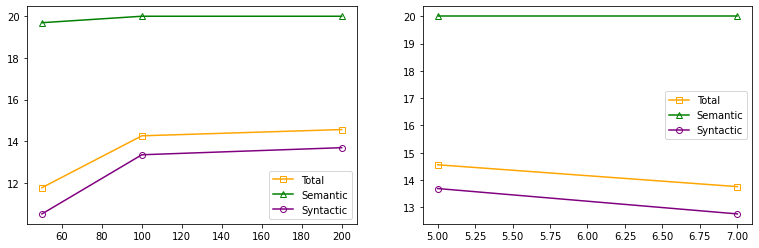

In [75]:
import matplotlib.pyplot as plt
x_dim = [50,100,200]
y_dim_tol = [11.77, 14.26, 14.56]
y_dim_sem = [19.69, 20.00, 20.00]
y_dim_syn = [10.51, 13.35, 13.69]
y_dim = [y_dim_tol, y_dim_sem, y_dim_syn]

x_window_size = [5,7]
y_window_size_tol = [14.56, 13.76]
y_window_size_sem = [20, 20]
y_window_size_syn = [13.69, 12.76]

plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plt.plot(x_dim, y_dim_tol, 's',ls='-',c='orange',markerfacecolor='none',label='Total')
plt.plot(x_dim, y_dim_sem, '^',ls='-',c='g',markerfacecolor='none',label='Semantic')
plt.plot(x_dim, y_dim_syn, 'o',ls='-',c='purple',markerfacecolor='none',label='Syntactic')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x_window_size, y_window_size_tol, 's',ls='-',c='orange',markerfacecolor='none',label='Total')
plt.plot(x_window_size, y_window_size_sem, '^',ls='-',c='g',markerfacecolor='none',label='Semantic')
plt.plot(x_window_size, y_window_size_syn, 'o',ls='-',c='purple',markerfacecolor='none',label='Syntactic')
plt.legend()

<table>
<tr>
<th>Dimension</th>
<th>Window size</th>
<th>Semantic accuracy</th>
<th>Syntactic accuracy</th>
<th>Total accuracy</th>
</tr>
<tr>
<td>50</td>
<td>5</td>
<td>19.69%</td>
<td>10.51%</td>
<td>11.77%</td>
</tr>
<tr>
<td>50</td>
<td>7</td>
<td>20.00%</td>
<td>9.98%</td>
<td>11.35%</td>
</tr>
<tr>
<td>100</td>
<td>5</td>
<td>20.00%</td>
<td>13.35%</td>
<td>14.26%</td>
</tr>
<tr>
<td>100</td>
<td>7</td>
<td>19.38%</td>
<td>11.44%</td>
<td>12.53%</td>
</tr>
<tr>
<td>200</td>
<td>5</td>
<td>20.00%</td>
<td>13.69%</td>
<td>14.56%</td>
</tr>
<tr>
<td>200</td>
<td>7</td>
<td>20.00%</td>
<td>12.76%</td>
<td>13.76%</td>
</tr>
</table>

## 4.2. Performance Evaluation with Data Processing Techiques

In [ ]:
from sklearn.metrics import f1_score
predict = torch.argmax(model(torch.from_numpy(np.array(test_encoded))), -1)
f1 = f1_score(label_encoded_testing, predict)
print('F1 Score: %.5f' %(f1))

Here is result of the classification model under different preprocessing techniques. The best model comes from the corpus removing urls and stopwords and stemming. The corpus without url is better than with url, I think that makes sense because url will have some irrelated words, so it may bring interferences when training our classification model. Also, some stopwords can be the interferences to our model as well. The core of a sentence should be verbs and nouns which are what the model should most concern with. So after removing that, the accuracy of the model get a very apparent increasement.

<table>
<tr>
<th>preprocessing technique</th>
<th>F1 Score</th>
</tr>
<tr>
<td>with_url</td>
<td>0.30052</td>
</tr>
<tr>
<td>without_url</td>
<td>0.41848</td>
</tr>
<tr>
<td>without_url_stopwords_stemming</td>
<td>0.76202</td>
</tr>
<tr>
<td>without_url_removing_number_lemmatisation</td>
<td>0.56849</td>
</tr>
</table>

## 4.3. Performance Evaluation with Different Input


You are required to evaluate with the testing dataset and provide the table with f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence and justification*)

In [107]:
# Please comment your code
from sklearn.metrics import f1_score
predict = torch.argmax(model(torch.from_numpy(np.array(test_encoded))), -1)
f1 = f1_score(label_encoded_testing, predict)
print('F1 Score: %.5f' %(f1))

F1 Score: 0.51515


The following result shows the F1 score of our classification model under different inputs. It can be seen that single cbow with dim=200 and window size=7 have the highest F1 Score. It's a little bit different from what I thought, because the combination one should have more details of the words. But the single Word2Vec model always get better result than combination one, that may result from the pretrained Word2Vec model doesn't suit well for the corpus of training data.

<table>
<tr>
<th>input</th>
<th>F1 Score</th>
</tr>
<tr>
<td>single cbow dim=200,window_size=7</td>
<td>0.81690</td>
</tr>
<tr>
<td>single skip-gram dim=200,window_size=7</td>
<td>0.79318</td>
</tr>
<tr>
<td>single glove-twitter-100</td>
<td>0.75318</td>
</tr>
<tr>
<td>single glove-wiki-gigaword-100</td>
<td>0.54570</td>
</tr>
<tr>
<td>combination of cbow dim=200,window_size=7 and glove-twitter-100</td>
<td>0.75094</td>
</tr>
<tr>
<td>combination of skip-gram dim=200,window_size=7 and glove-wiki-gigaword-100</td>
<td>0.51515</td>
</tr>
</table>

## 4.4. Performance Evaluation with Different Sequence Models


You are required to evaluate with the testing dataset and provide the table with f1 of test set.
Note that it will not be marked if you do not display it in the ipynb file.


(*Please show your empirical evidence and justification*)

In [118]:
from sklearn.metrics import f1_score
predict = torch.argmax(model(torch.from_numpy(np.array(test_encoded))), -1)
f1 = f1_score(label_encoded_testing, predict)
print('F1 Score: %.5f' %(f1))

F1 Score: 0.51762


The following shows the F1 Score under different Seq2Seq Model. It can be seen that Bi-LSTM have higher score here. It's much better than RNN. I think it may result from the stucture of the model itself. When the sentence goes so long, the Bi-RNN model cannot deal with it very well.

<table>
<tr>
<th>Seq2Seq Model</th>
<th>F1 Score</th>
</tr>
<tr>
<td>Bi-RNN</td>
<td>0.51762</td>
</tr>
<tr>
<td>Bi-LSTM</td>
<td>0.81690</td>
</tr>
</table>

## 4.5. HyperParameter Testing

In [132]:
# Please comment your code
from sklearn.metrics import f1_score
predict = torch.argmax(model(torch.from_numpy(np.array(test_encoded))), -1)
f1 = f1_score(label_encoded_testing, predict)
print('F1 Score: %.5f' %(f1))

F1 Score: 0.73881


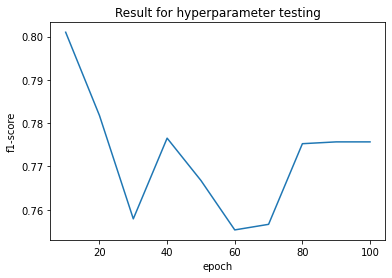

In [1]:
import matplotlib.pyplot as plt

xAxis = [10,20,30,40,50,60,70,80,90,100]
yAxis = [0.80100, 0.78175, 0.75789, 0.77653, 0.76675, 0.75533, 0.75662, 0.77525, 0.77567, 0.77567]
plt.plot(xAxis,yAxis)
plt.title('Result for hyperparameter testing')
plt.xlabel('epoch')
plt.ylabel('f1-score')
plt.show()

Here is the result of F1 Score with different epoch, it shows the best F1 Score appears when epoch = 10, and after 60, the f1 score starts to stable and keeps on around 0.775. The trend of the epoch number and f1 score would be, decrease first and obtain th lowest point at epoch=60, then increase to 0.775, after that, it starts to keep stable.

<table>
<th>Epoch</th>
<th>F1 Score</th>
<tr>
<td>10</td>
<td>0.80100</td>
</tr>
<tr>
<td>20</td>
<td>0.78175</td>
</tr>
<tr>
<td>30</td>
<td>0.75789</td>
</tr>
<tr>
<td>40</td>
<td>0.77653</td>
</tr>
<tr>
<td>50</td>
<td>0.76675</td>
</tr>
<tr>
<td>60</td>
<td>0.75533</td>
</tr>
<tr>
<td>70</td>
<td>0.75662</td>
</tr>
<tr>
<td>80</td>
<td>0.77525</td>
</tr>
<tr>
<td>90</td>
<td>0.77567</td>
</tr>
<tr>
<td>100</td>
<td>0.77567</td>
</tr>
</table>

#5 - Test your model via Colab Form Fields User Interface

You are required to design a user interface so that user can input a textual sentence via the colab form fields user interface to get the personality type classification result from your trained model. *You can just modify based on the following Colab Form Fields template*

In [55]:
#@title Personality Type Prediction

text = "it sounds you don't like a feeling person" #@param {type:"string"}
try:
  data_after_preprocessing = stemming(remove_stop_words(remove_punctuation(remove_contraction(remove_url([text])))))
  data_encoded = encode_and_add_padding(data_after_preprocessing, seq_length, word_index)
  # print(data_encoded)
  my_predict = torch.argmax(the_saved_model(torch.from_numpy(np.array(data_encoded))), -1)[0].item()
  if(my_predict == 1):
    print('Thinking')
  else:
    print('Feeling')
except:
  print('error')

Thinking
